# Social Doors Cerebellum PPI Analysis

Author: Haroon Popal 

Code borrowed from [dartbrains](https://dartbrains.org/content/Connectivity.html#psychophysiological-interactions)

## Set Up

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask
from nltools.stats import fdr, threshold, fisher_r_to_z, one_sample_permutation, zscore
from sklearn.metrics import pairwise_distances
from matplotlib.gridspec import GridSpec

from nilearn.image import math_img, smooth_img
from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_glass_brain
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img

# Import cerebellum packages
#import matplotlib.pyplot as plt
#import SUITPy.flatmap as flatmap

import importlib

import helpful_functions
importlib.reload(helpful_functions)


import warnings
warnings.filterwarnings('ignore')

/Users/haroonpopal/anaconda3/envs/py37/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


### Set Paths

In [2]:
bids_dir = '/Users/haroonpopal/OneDrive - Temple University/olson_lab/projects/social_doors/'
os.chdir(bids_dir)

outp_dir = os.path.join(bids_dir, 'derivatives', 'ppi_analysis')
data_dir = os.path.join(bids_dir, 'derivatives','social_doors-nilearn')

if os.path.exists(outp_dir):
    print('Output directory already exists. Continuing will overwrite data.')
else:
    os.makedirs(outp_dir)

Output directory already exists. Continuing will overwrite data.


### Import participant list

In [3]:
subjs_scan_info = pd.read_csv(bids_dir+'derivatives/participants_good.tsv', sep='\t')

subjs_list = list(subjs_scan_info['participant_id'].unique())
len(subjs_list)

# Remove bad participant
subjs_list = [x for x in subjs_list if x != 'sub-4069']

subjs_list.sort()
print('Found '+str(len(subjs_list))+' subjects')
subj = subjs_list[0]

Found 62 subjects


In [8]:
subjs_scan_info.head()

,Unnamed: 0,participant_id,age,sex,group
0,0,sub-010,13,F,kid
1,2,sub-013,13,M,kid
2,5,sub-028,15,M,kid
3,6,sub-036,16,F,kid
4,7,sub-5049,12,F,kid


### Import MRI quality control info

In [9]:
qc_summary = pd.read_csv('derivatives/qc_summary.csv')

# Filter qc summary for only good participants
qc_summary_good = qc_summary[qc_summary['subject'].isin(subjs_list)]
qc_summary_good.head()

,subject,run,rating,artifacts
0,sub-010,mdoors_run-1,4,[]
1,sub-010,mdoors_run-2,3,['head-motion']
2,sub-010,social_run-1,4,[]
3,sub-010,social_run-2,4,[]
8,sub-013,mdoors_run-1,3,"['head-motion','parietal-cutoff']"


# Single Subject Analysis
This will complete the PPI analysis for a single subject to explain each step of the process, before running for all participants

## Set up task info

In [10]:
task = 'social'

func_run_names = qc_summary[(qc_summary['subject'] == subj) & (qc_summary['run'].str.contains(task))]
func_run_names = func_run_names['run'].to_list()

## Find functional data

In [11]:
# Find functinoal runs that passed quality control
func_runs = []
for run in func_run_names:
    func_runs.append(glob.glob(os.path.join(bids_dir, 'derivatives', 'fmriprep', subj, 'func',
                                   subj+'_task-'+run+'_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))[0])

# Set a grey matter mask
subj_gm_mask = 'derivatives/fmriprep/'+subj+'/anat/'+subj+'_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz'
data = Brain_Data(func_runs, mask=subj_gm_mask)

# Smooth data
fwhm=6
smoothed = data.smooth(fwhm=fwhm)

## Set an ROI
The region of interest (ROI) used here is "region 8" from the MDTB cerebellum atlas from [King et al., 2019](https://www.nature.com/articles/s41593-019-0436-x).

In [12]:
roi_names = ['region08']

rois_dict = {}

for n in range(len(roi_names)):
    roi_path = glob.glob(os.path.join(bids_dir, 'derivatives','rois',
                                                    'mdtb_'+roi_names[n]+'.nii.gz'))
    rois_dict[roi_names[n]] = Brain_Data(roi_path, mask=subj_gm_mask)

### Import networks of interest
For this analysis, we will examine the connectivity of the cerebellum to a social brain network and the reward network, as defined by neurosynth.

#### Social Network

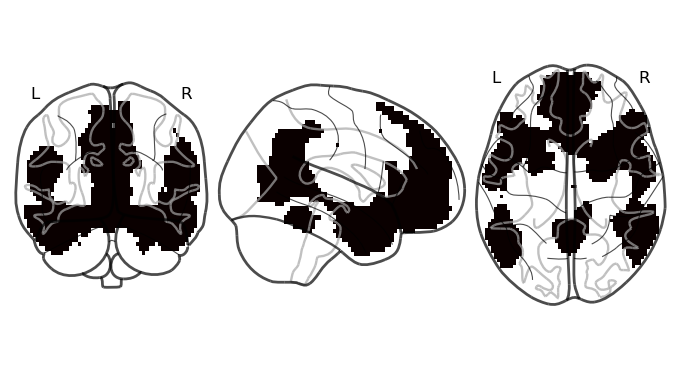

In [13]:
social_net = Brain_Data(os.path.join(bids_dir, 'derivatives','nimare', 
                                     'neurosynth_term-social_z_desc-association.nii.gz'), 
                       mask=subj_gm_mask)

# Mask out the cerebellum
cb_mask = Brain_Data(os.path.join(bids_dir, 'derivatives', 'social_doors-nilearn', 
                                  subj, 'suit', 'iw_c_sub-010_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w_pcereb_u_a_sub-010_run-1_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz'),
                     mask = subj_gm_mask)

social_net.data[cb_mask.data > 0] = 0

# Smooth
social_net_sm = smooth_img(social_net.to_nifti(), 4)

# Filter for Z-score equivalent to p = .001
social_net_sm_bin = math_img('img > 3.09', img=social_net_sm)

plot_glass_brain(social_net_sm_bin)

#### Reward Network

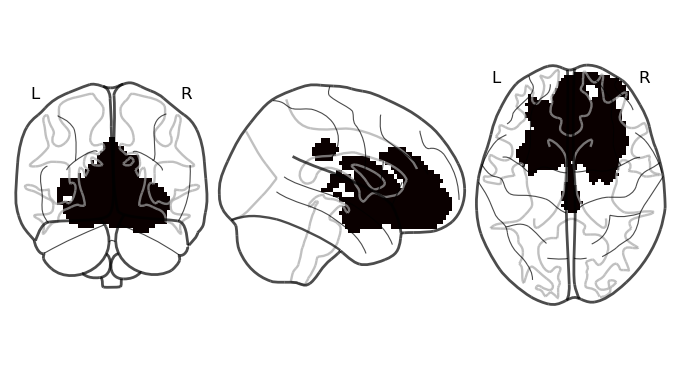

In [14]:
reward_net = Brain_Data(os.path.join(bids_dir, 'derivatives','nimare', 
                                     'neurosynth_term-reward_z_desc-association.nii.gz'), 
                       mask=subj_gm_mask)

# Mask out the cerebellum
cb_mask = Brain_Data(os.path.join(bids_dir, 'derivatives', 'social_doors-nilearn', 
                                  subj, 'suit', 'iw_c_sub-010_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w_pcereb_u_a_sub-010_run-1_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz'),
                     mask = subj_gm_mask)

reward_net.data[cb_mask.data > 0] = 0

# Smooth
reward_net_sm = smooth_img(reward_net.to_nifti(), 4)

# Filter for Z-score equivalent to p = .001
reward_net_sm_bin = math_img('img > 3.09', img=reward_net_sm)

plot_glass_brain(reward_net_sm_bin)

## Extract Data

Text(0.5, 0, 'Time (TRs)')

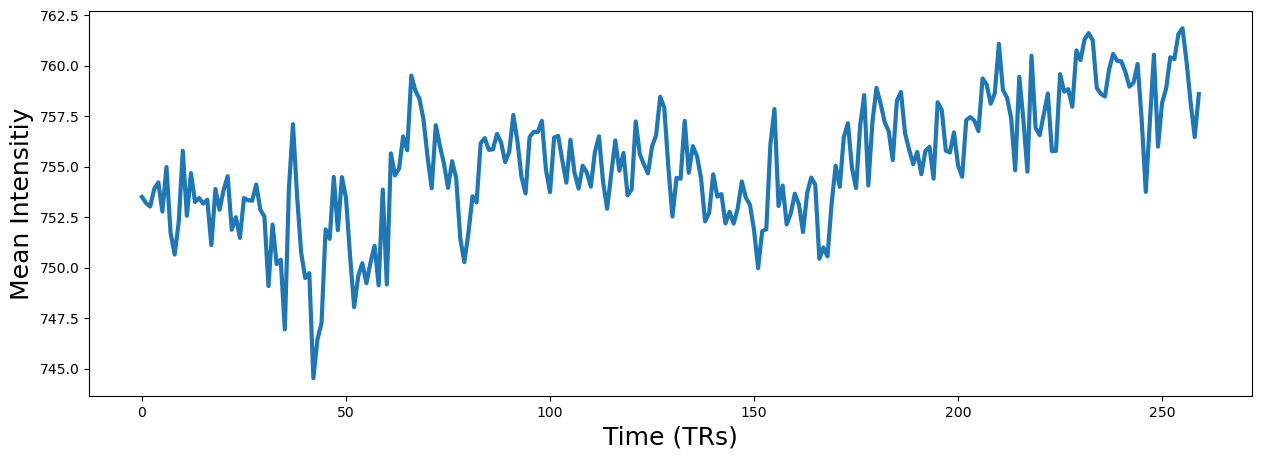

In [15]:
cb_data = smoothed.extract_roi(mask=rois_dict['region08'])

plt.figure(figsize=(15,5))
plt.plot(cb_data, linewidth=3)
plt.ylabel('Mean Intensitiy', fontsize=18)
plt.xlabel('Time (TRs)', fontsize=18)

## Create design matrix

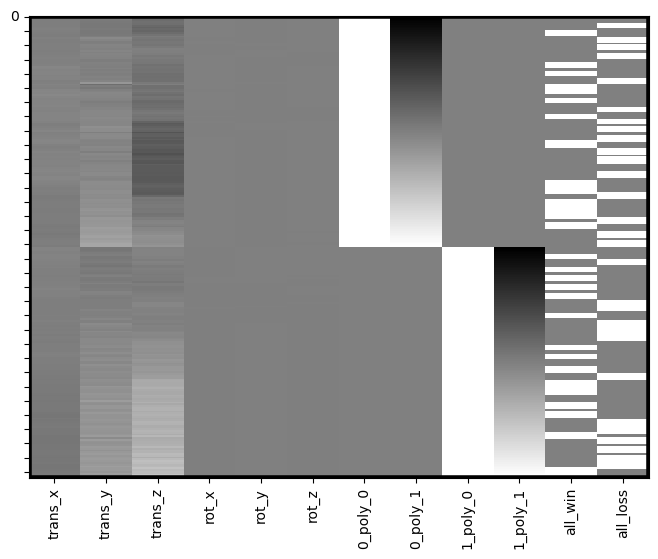

In [16]:
# Set TR info
tr = 2.1
n_tr = len(data)

# z-score cerebellum time series
cb_data = zscore(pd.DataFrame(cb_data, columns=['region08']))


# Append run design matrices
dm = pd.DataFrame()
for run in func_run_names:
    run_n = int(run[-1])
    
    # Import design matrix for a single run
    temp_dm = pd.read_csv(outp_dir+'/design_matrices/'+subj+'_task-'+run+'_desc-design_matrix.csv')

    # Rename the first and second order polynomial regressors so that they do not 
    # regressor between runs
    temp_dm = temp_dm.rename(columns={"poly_0": str(run_n-1)+"_poly_0", "poly_1": str(run_n-1)+"_poly_1"})
    
    # Append design matrix into a longer design matrix
    dm = pd.concat([dm, temp_dm], ignore_index=True)


# Fill NaNs with 0s. NaNs came from renaming columns and then appending the design matrices
dm = dm.fillna(0)

# Join Design matrix with roi time course
dm = Design_Matrix(pd.concat([cb_data, dm], axis=1), sampling_freq=1/tr)


# Create all win and all loss. conditions
dm['all_win'] = dm['positive_win'] + dm['negative_win']
dm['all_loss'] = dm['positive_loss'] + dm['negative_loss']

# Remove irrelevant conditions and create a new dm
ppi_dm = dm.drop(['positive_win', 'positive_loss',
                  'negative_win', 'negative_loss', 
                  'negative', 'positive', 
                  'fixation', 'region08'], axis=1)


# Plot design matrix
ppi_dm.heatmap()

## Psychophysiological Interaction Analysis

### Add region x condition interaction terms
For this analysis we will use a generalized PPI framework in which we take the interaction of each condition of interest with the time series of an ROI

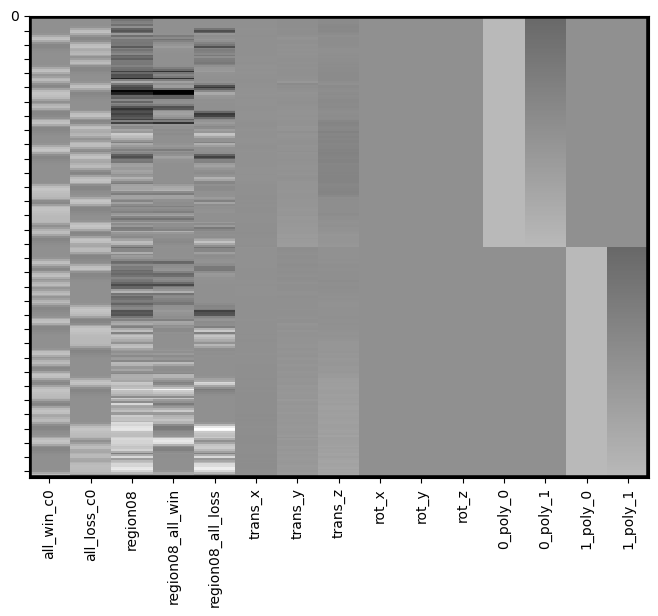

In [17]:
# Find motion regressors
mc_cov = ppi_dm[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]

# Find polynomial regressors
poly_cov = ppi_dm.loc[:, ppi_dm.columns.str.contains('_poly_')]

# Remove motion and polynomial regressors
ppi_dm = ppi_dm.drop(mc_cov.columns, axis=1)
ppi_dm = ppi_dm.drop(poly_cov.columns, axis=1)

# Complete convolution
ppi_dm_conv = ppi_dm.convolve()

# Add ROI time series
ppi_dm_conv['region08'] = cb_data


# Create generalized interaction terms
ppi_dm_conv['region08_all_win'] = ppi_dm_conv['region08']*ppi_dm_conv['all_win_c0']
ppi_dm_conv['region08_all_loss'] = ppi_dm_conv['region08']*ppi_dm_conv['all_loss_c0']


ppi_dm_conv_all = Design_Matrix(pd.concat([ppi_dm_conv, mc_cov, poly_cov], axis=1), sampling_freq=1/tr)


ppi_dm_conv_all.heatmap()

### Regress onto the whole brain

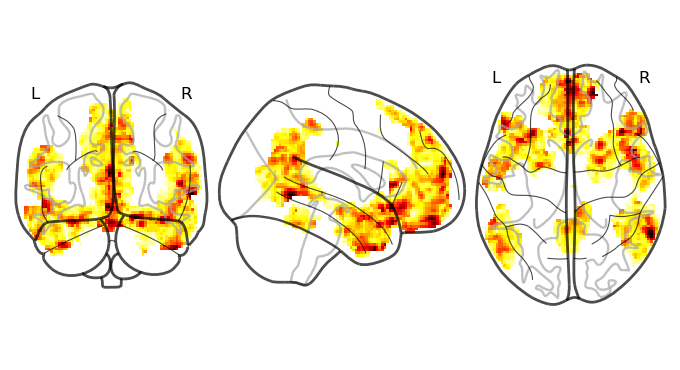

In [18]:
# Apply mask
smoothed_social = smoothed.apply_mask(social_net_sm_bin)

smoothed_social.X = ppi_dm_conv_all

ppi_stats = smoothed_social.regress()

# Create all win vs all loss PPI contrast
c1 = np.zeros(len(ppi_stats['beta']))
idx_1 = list(smoothed_social.X.columns).index('region08_all_win')
idx_2 = list(smoothed_social.X.columns).index('region08_all_loss')

c1[idx_1] = 1
c1[idx_2] = -1


cb_r_fixation_ppi = ppi_stats['beta'] * c1

#cb_r_fixation_ppi = ppi_stats['beta'][int(np.where(smoothed.X.columns=='region08_all_win')[0][0])]

#cb_r_fixation_ppi.plot()
plot_glass_brain(cb_r_fixation_ppi.to_nifti())

# Group PPI Analysis

In [19]:
# Remove bad participant
subjs_list = [x for x in subjs_list if x != 'sub-4069']

In [20]:
seed = 'region08'
fwhm=6

tasks = ['mdoors', 'social']
network_rois = ['reward', 'social']

network_masks = {}
network_masks['reward'] = reward_net_sm_bin
network_masks['social'] = social_net_sm_bin

In [ ]:
all_sub_ppi_cb = {}

all_sub_ppi_cb['task-mdoors_roi-reward'] = Brain_Data()
all_sub_ppi_cb['task-mdoors_roi-social'] = Brain_Data()
all_sub_ppi_cb['task-social_roi-reward'] = Brain_Data()
all_sub_ppi_cb['task-social_roi-social'] = Brain_Data()




ppi_roi_stats = pd.DataFrame(columns=['subject_id','seed','task','roi','mean'])


for subj in subjs_list:
    print('Calculating PPI for '+subj)
    
    for task in tasks:
        # Import functional runs that passed quality control
        #func_run_nums =  [s.lstrip('0') for s in subjs_scan_info[subjs_scan_info['subject']==subj]['run'].str[-8:-5]]
        #func_run_nums = [int(i) for i in func_run_nums]
        func_run_names = qc_summary[(qc_summary['subject'] == subj) & (qc_summary['run'].str.contains(task))]
        func_run_names = func_run_names['run'].to_list()

        print('Number of functional runs for '+subj+': '+str(len(func_run_names)))

        # Find functional runs that passed quality control
        func_runs = []
        for run in func_run_names:
            func_runs.append(glob.glob(os.path.join(bids_dir, 'derivatives', 'fmriprep', subj, 'func',
                                       subj+'_task-'+run+'_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))[0])


        # Import functional data, masked for only grey matter
        mni_gm_mask = 'derivatives/fmriprep/sub-010/anat/sub-010_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz'
        #comn_mni_mask = "derivatives/fmriprep/sub-301/ses-001/func/sub-301_ses-001_task-relscenarios_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
        data = Brain_Data(func_runs, mask=mni_gm_mask)


        # Smooth data
        smoothed = data.smooth(fwhm=fwhm)


        # Extract cerebellum ROI data
        cb_data = smoothed.extract_roi(mask=rois_dict[seed])


        # Get functional meta data
        #tr = layout.get_tr()
        n_tr = len(data)


        # Z-score cerebellum time series
        cb_data = zscore(pd.DataFrame(cb_data, columns=[seed]))


        # Import Design matrix for all runs
        #dm = pd.read_csv(bids_dir+'/derivatives/fmriprep/'+subj+'/ses-001/func/'+subj+'_ses-001_task-relscenarios_run-all_cat_desc-design_matrix.csv')
        #cb_data_dm = Design_Matrix(cb_data, sampling_freq=1/tr).convolve()
        dm = pd.DataFrame()
        for run in func_run_names:
            run_n = int(run[-1])
            # Import design matrix for a single run
            temp_dm = pd.read_csv(outp_dir+'/design_matrices/'+subj+'_task-'+run+'_desc-design_matrix.csv')
            # Rename the first and second order polynomial regressors so that they do not 
            # regressor between runs
            temp_dm = temp_dm.rename(columns={"poly_0": str(run_n-1)+"_poly_0", "poly_1": str(run_n-1)+"_poly_1"})

            # Append design matrix into a longer design matrix
            #dm = dm.append(temp_dm, ignore_index=True)
            dm = pd.concat([dm, temp_dm], ignore_index=True)

        # Fill NaNs with 0s. NaNs came from renaming columns and then appending the design matrices
        dm = dm.fillna(0)

        # Combine cerebellum time series with the design matrix
        #ppi_dm = Design_Matrix(pd.concat([cb_data, dm], axis=1), sampling_freq=1/tr)

        if 'positive_win' not in dm.columns:
            continue
        
        # Create all win and all loss. conditions
        dm['all_win'] = dm['positive_win'] + dm['negative_win']
        dm['all_loss'] = dm['positive_loss'] + dm['negative_loss']

        # Remove irrelevant conditions and create a new dm
        dm = dm.drop(['positive_win', 'positive_loss',
                          'negative_win', 'negative_loss', 
                          'negative', 'positive', 
                          'fixation'], axis=1)


        #ppi_dm = dm.drop(['CB_r'], axis=1)

        mc_cov = dm[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
        poly_cov = dm.loc[:, dm.columns.str.contains('_poly_')]

        ppi_dm = dm.drop(mc_cov.columns, axis=1)
        ppi_dm = ppi_dm.drop(poly_cov.columns, axis=1)

        ppi_dm = Design_Matrix(ppi_dm, sampling_freq=1/tr)
        ppi_dm_conv = ppi_dm.convolve()

        ppi_dm_conv[seed] = cb_data

        # Create generalized interaction terms
        ppi_dm_conv['region08_all_win'] = ppi_dm_conv['region08']*ppi_dm_conv['all_win_c0']
        ppi_dm_conv['region08_all_loss'] = ppi_dm_conv['region08']*ppi_dm_conv['all_loss_c0']

        ppi_dm_conv_all = Design_Matrix(pd.concat([ppi_dm_conv, mc_cov, poly_cov], axis=1), sampling_freq=1/tr)


        # Convolve design matrix
        #ppi_dm_conv = ppi_dm.convolve()


        # Calculate interaction term
        #ppi_dm_conv['CB_r_All'] = ppi_dm_conv['CB_r_c0']*ppi_dm_conv['All_c0']
    
    
        for net_roi in network_rois:
            smoothed_net = smoothed.apply_mask(network_masks[net_roi])
            
            
            # Run PPI
            smoothed_net.X = ppi_dm_conv_all
            ppi_stats = smoothed_net.regress()

            # Create all win vs all loss PPI contrast
            c1 = np.zeros(len(ppi_stats['beta']))
            idx_1 = list(smoothed_net.X.columns).index('region08_all_win')
            idx_2 = list(smoothed_net.X.columns).index('region08_all_loss')

            c1[idx_1] = 1
            c1[idx_2] = -1

            # Calculate contrast
            cb_r_fixation_ppi = ppi_stats['beta'] * c1


            # Export PPI map
            cb_r_fixation_ppi.to_nifti().to_filename(os.path.join(outp_dir,'subject_results',
                                                                  subj, subj+'_ppi_'+seed+'_task-'+task+'_netroi-'+net_roi+'.nii.gz'))
            
            # Save mean data for ROI
            temp_mean = cb_r_fixation_ppi.extract_roi(mask=network_masks[net_roi])
            ppi_roi_stats.loc[len(ppi_roi_stats)] = [subj,seed,task,net_roi,temp_mean]
            ppi_roi_stats.to_csv(outp_dir+'/ppi_seed-'+seed+'network_roi_stats.csv', index=False)

            # Append subject data
            all_sub_ppi_cb['task-'+task+'_roi-'+net_roi] = all_sub_ppi_cb['task-'+task+'_roi-'+net_roi].append(cb_r_fixation_ppi)
            


Calculating PPI for sub-010
Number of functional runs for sub-010: 2
Number of functional runs for sub-010: 2


In [33]:
cb_r_fixation_ppi.data.shape

(24003,)

In [30]:
cb_r_fixation_ppi.extract_roi(mask=network_masks[net_roi])

-0.10815892867362863

# All Participants Group Average

In [25]:
ppi_roi_stats['mean']

0     -7.780782e-11
1     -5.132988e-07
2     -2.119683e-11
3     -5.449416e-07
4     -2.335947e-10
           ...     
241    1.063826e-06
242   -1.242925e-10
243   -5.012068e-07
244   -2.164100e-10
245    2.500688e-06
Name: mean, Length: 246, dtype: float64

In [24]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('mean ~ C(task) + C(roi) + C(task):C(roi)', 
            data=ppi_roi_stats).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(task),6.516803e-13,1.0,0.594787,0.441326
C(roi),1.405871e-14,1.0,0.012831,0.909906
C(task):C(roi),6.519485e-13,1.0,0.595032,0.441232
Residual,2.651481e-10,242.0,NaN,NaN


In [ ]:
sns.boxplot(data=all_sub_ppi_roi_df, x='network', y='beta', hue='task')
plt.xticks(rotation=45)

## Young Adults

**Results:** No significant clusters, but a more liberal threshold shows more positive correlations between Crus I/II with vmPFC, dlPFC, and more negative correlation with the ventral stream for all wins than for all losses.

In [78]:
subjs_scan_info = subjs_scan_info[subjs_scan_info['participant_id'] != 'sub-4069']
subjs_scan_info = subjs_scan_info[subjs_scan_info['participant_id'] != 'sub-3880']

In [79]:
# Create list of young adult data
subjs_scan_info_adult = subjs_scan_info[subjs_scan_info['group'] == 'college']
print('There are ' + str(len(subjs_scan_info_adult))+ ' young adults')

file_list_adult_ppi = []

for subj in subjs_scan_info_adult['participant_id']:
    file_list_adult_ppi.append(glob.glob(os.path.join(outp_dir,'subject_results',
                                                      subj, subj+'_ppi_region08.nii'))[0])


print('Found '+str(len(file_list_adult_ppi))+' subject maps')

There are 29 young adults
Found 29 subject maps


In [80]:
network_rois

['reward', 'social']

In [81]:
mni_gm_mask = 'derivatives/fmriprep/sub-010/anat/sub-010_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz'

contrasts=['netroi-reward', 'netroi-social']
group = 'adult'
tasks = ['mdoors', 'social']
alpha = 0.05
mc = 'fdr'


threshold_data = {}

for task in tasks:
    for contrast in contrasts:
        file_list_adult_ppi = []
        for subj in subjs_scan_info_adult['participant_id']:
            file_list_adult_ppi.append(glob.glob(os.path.join(outp_dir,'subject_results',
                                                          subj, subj+'_ppi_'+roi+'_task-'+task+'_'+contrast+'.nii.gz'))[0])

        print('Calculating PPI analysis for '+task+' '+contrast)
        
        design_matrix = make_second_level_design_matrix(subjs_scan_info_adult['participant_id'])
        model = SecondLevelModel(mask_img=network_masks[contrast.split('-')[1]], smoothing_fwhm=8.0)
        model.fit(file_list_adult_ppi, design_matrix=design_matrix)
        
        contrast_stats = model.compute_contrast(output_type='all')
        z_map = contrast_stats['z_score']
        e_map = contrast_stats['effect_size']

        z_map.to_filename(os.path.join(outp_dir,'group_results',
                                   group+'_ppi_'+roi+'_task-'+task+'_'+contrast+'_zmap.nii.gz'))
        e_map.to_filename(os.path.join(outp_dir,'group_results',
                                   group+'_ppi_'+roi+'_task-'+task+'_'+contrast+'_effect.nii.gz'))
            
        # Multiple Comparisons Correction
        z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)

        z_map_thresh.to_filename(os.path.join(outp_dir,'group_results',
                                   group+'_ppi_'+roi+'_task-'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)+'.nii.gz'))
            
        threshold_data[group+'_ppi_'+roi+'_task-'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)] = threshold

Calculating PPI analysis for mdoors netroi-reward
Calculating PPI analysis for mdoors netroi-social
Calculating PPI analysis for social netroi-reward
Calculating PPI analysis for social netroi-social


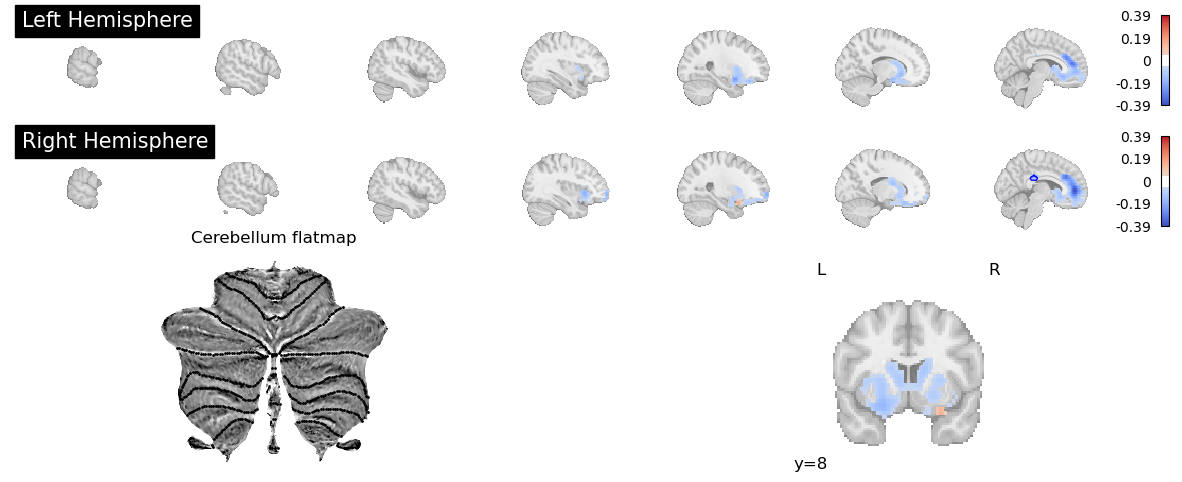

In [7]:
filename = outp_dir+'/group_results/'+'adult_ppi_region08_task-mdoors_netroi-reward'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

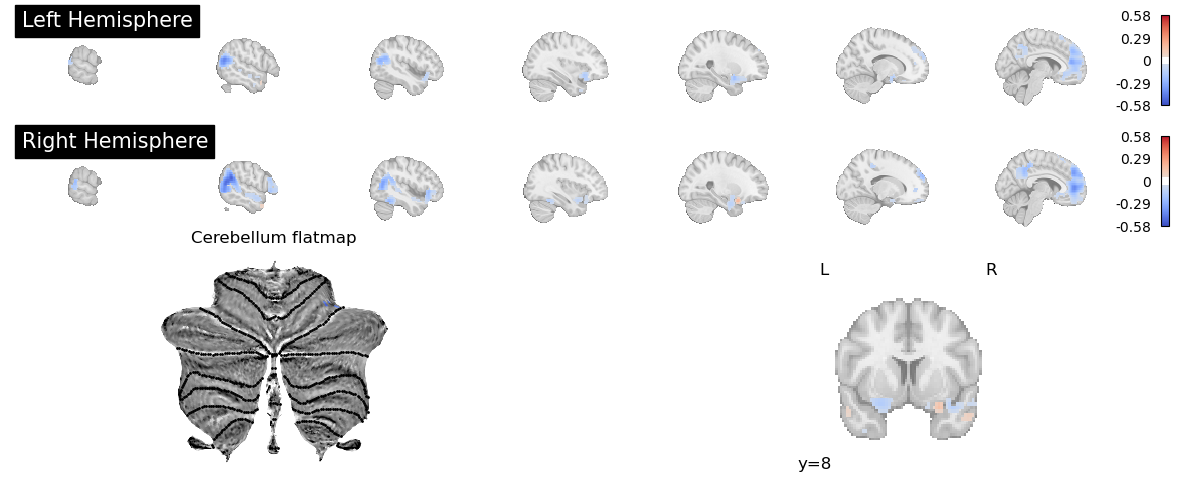

In [8]:
filename = outp_dir+'/group_results/'+'adult_ppi_region08_task-mdoors_netroi-social'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

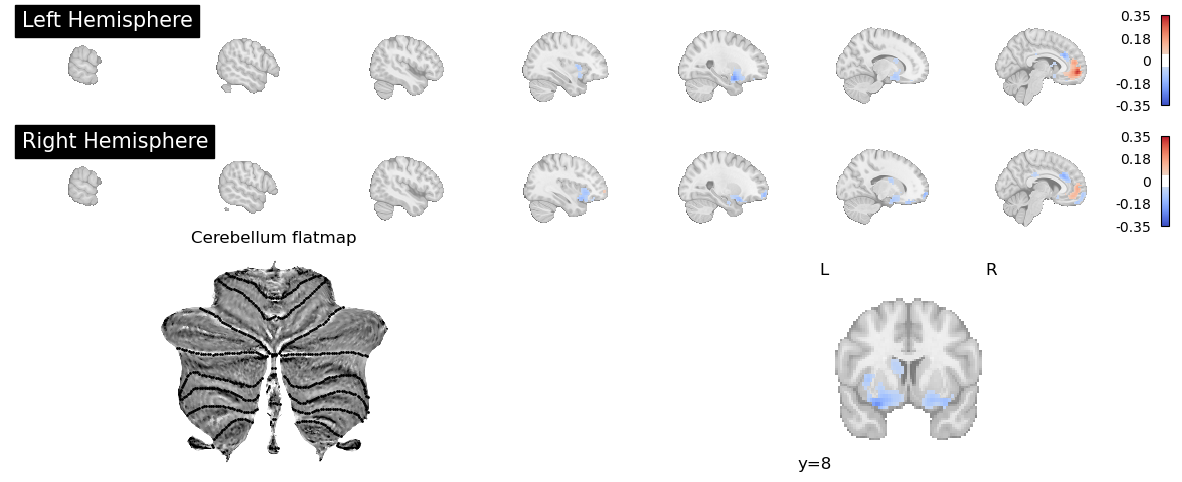

In [9]:
filename = outp_dir+'/group_results/'+'adult_ppi_region08_task-social_netroi-reward'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

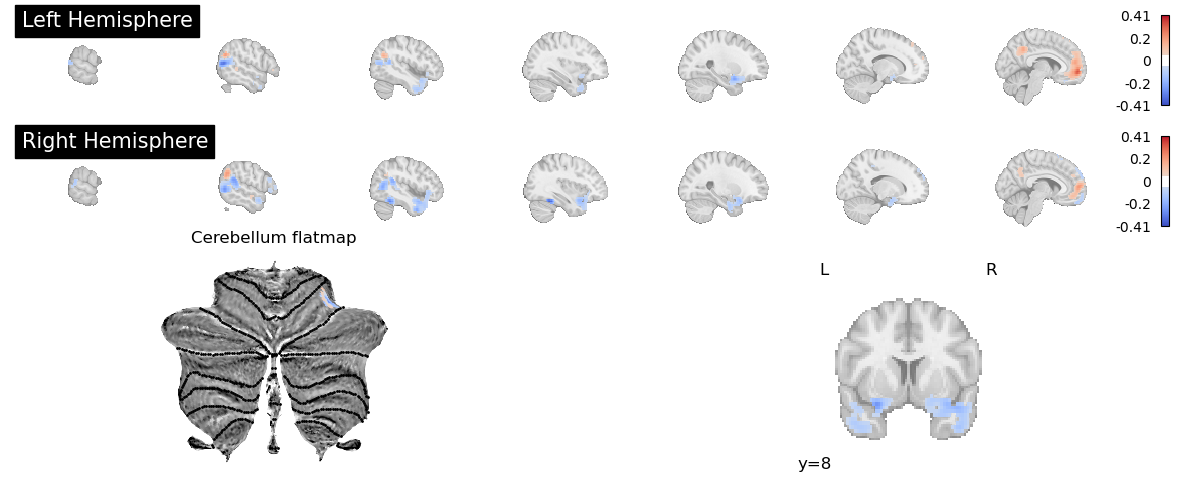

In [10]:
filename = outp_dir+'/group_results/'+'adult_ppi_region08_task-social_netroi-social'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

## Adolescents

In [27]:
# Create list of adolescent data
subjs_scan_info_adole = subjs_scan_info[subjs_scan_info['group'] == 'kid']
print('There are ' + str(len(subjs_scan_info_adole))+ ' adolescents')

# Find PPI maps
file_list_adole_ppi = []

for subj in subjs_scan_info_adole['participant_id']:
    file_list_adole_ppi.append(glob.glob(os.path.join(outp_dir, 'subject_results',
                                                      subj, subj+'_ppi_region08.nii'))[0])


print('Found '+str(len(file_list_adole_ppi))+' subject maps')

There are 32 adolescents
Found 32 subject maps


In [30]:
mni_gm_mask = 'derivatives/fmriprep/sub-010/anat/sub-010_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz'

contrasts=['netroi-reward', 'netroi-social']
group = 'adole'
tasks = ['mdoors', 'social']
alpha = 0.05
mc = 'fdr'


threshold_data = {}

for task in tasks:
    for contrast in contrasts:
        file_list_adole_ppi = []
        for subj in subjs_scan_info_adole['participant_id']:
            file_list_adole_ppi.append(glob.glob(os.path.join(outp_dir,'subject_results',
                                                          subj, subj+'_ppi_'+seed+'_task-'+task+'_'+contrast+'.nii.gz'))[0])

        print('Calculating PPI analysis for '+task+' '+contrast)
        
        design_matrix = make_second_level_design_matrix(subjs_scan_info_adole['participant_id'])
        
        # Define the network roi name
        roi_name = contrast.split('-')[1]
        
        model = SecondLevelModel(mask_img=network_masks[roi_name], smoothing_fwhm=8.0)
        model.fit(file_list_adole_ppi, design_matrix=design_matrix)
        
        contrast_stats = model.compute_contrast(output_type='all')
        z_map = contrast_stats['z_score']
        e_map = contrast_stats['effect_size']

        z_map.to_filename(os.path.join(outp_dir,'group_results',
                                   group+'_ppi_'+seed+'_task-'+task+'_'+contrast+'_zmap.nii.gz'))
        e_map.to_filename(os.path.join(outp_dir,'group_results',
                                   group+'_ppi_'+seed+'_task-'+task+'_'+contrast+'_effect.nii.gz'))
            
        # Multiple Comparisons Correction
        z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)

        z_map_thresh.to_filename(os.path.join(outp_dir,'group_results',
                                   group+'_ppi_'+roi+'_task-'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)+'.nii.gz'))
            
        # Save mean for roi
        

Calculating PPI analysis for mdoors netroi-reward
Calculating PPI analysis for mdoors netroi-social
Calculating PPI analysis for social netroi-reward
Calculating PPI analysis for social netroi-social


In [47]:
contrast.split('-')[1]

'social'

In [39]:
network_masks['reward'].dataobj

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

0.04963225780159661

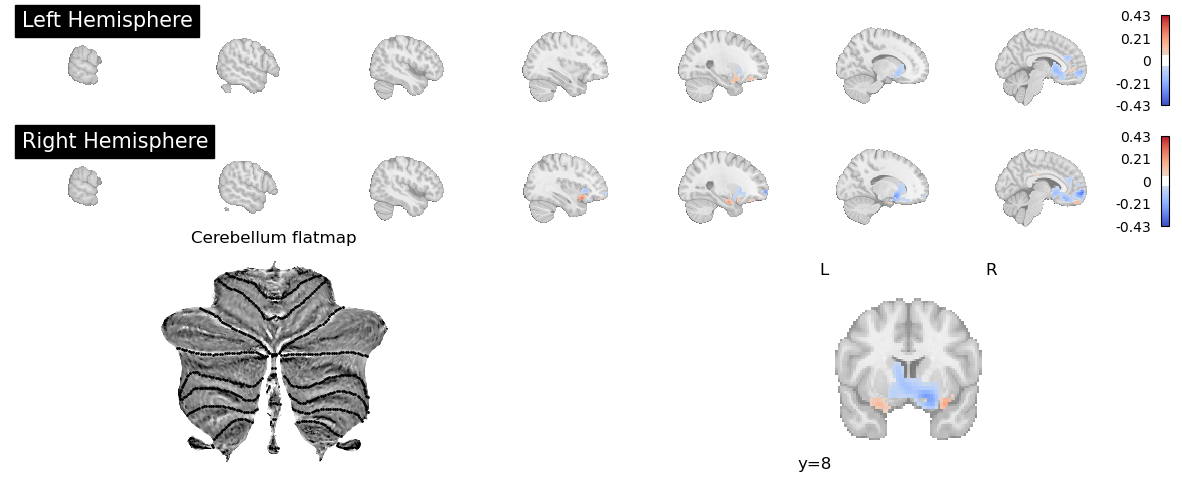

In [31]:
filename = outp_dir+'/group_results/'+'adole_ppi_region08_task-mdoors_netroi-reward'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

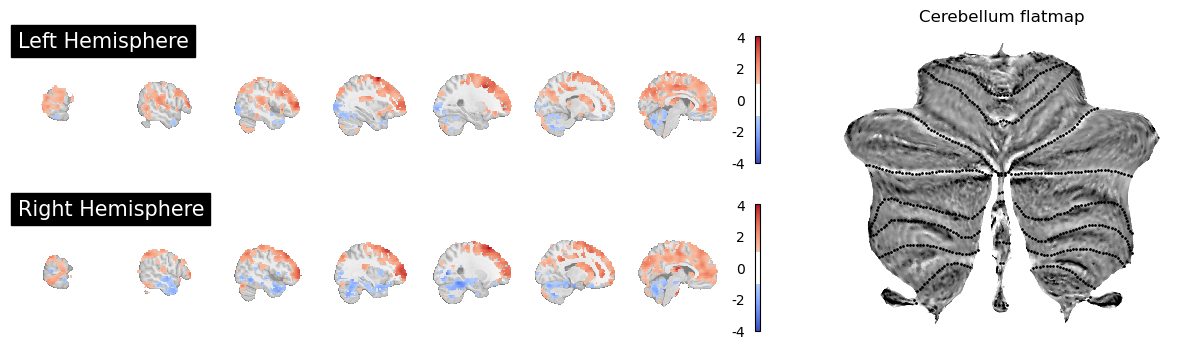

In [23]:
plot_stat_contours('zmap_ppi_region08_adole', mc='fdr', mc_alpha=0.05, thresh=1)

**Results:** No significant clusters. However, a liberal thershold shows greater positive correlations between Crus I/II and the frontal pole for all wins than for losses.

# Between Groups

## Second Level Design Matrix

In [35]:
# Remove bad participant
subjs_list = [x for x in subjs_list if x != 'sub-4069']

<AxesSubplot:label='conditions', ylabel='scan number'>

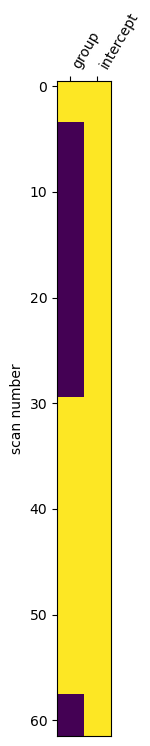

In [36]:
# Make a copy for the design matrix df
subjs_info_num = subjs_scan_info.copy()

# Remove bad subjects
subjs_info_num = subjs_info_num[subjs_info_num['participant_id'] != 'sub-4069']


# Turn values numeric
subjs_info_num = subjs_info_num.replace({'group': {'college': -1, 'kid': 1}})

# Remove irrelevant info
subjs_info_num = subjs_info_num.drop(columns=['age', 'sex', 'Unnamed: 0'])

# Change column header for needed function input
subjs_info_num = subjs_info_num.rename({'participant_id':'subject_label'}, axis='columns')

design_matrix = make_second_level_design_matrix(subjs_list, subjs_info_num)

plot_design_matrix(design_matrix)

In [38]:
# Find PPI data
file_list = []
for subj in subjs_list:
    file_list.append(glob.glob(os.path.join(outp_dir, 'subject_results',
                                            subj, subj+'_ppi_region08.nii'))[0])

# Create second level model
model = SecondLevelModel(mask_img=subj_mni_mask, smoothing_fwhm=8.0)
model.fit(file_list, design_matrix=design_matrix)

#Compute a contrast map to see whether any regions are greater than 0
z_map = model.compute_contrast('group', output_type='z_score')
z_map.to_filename(os.path.join(outp_dir, 'group_results','zmap_ppi_region08_adoleVadult_unc.nii.gz'))
            
# Multiple Comparisons Correction
z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)
z_map_thresh.to_filename(os.path.join(outp_dir, 'group_results', 
                                      'zmap_ppi_region08_adoleVadult_'+mc+'-'+str(alpha)+'.nii.gz'))
            
threshold_data['zmap_ppi_region08_adoleVadult_'+mc+'-'+str(alpha)] = threshold

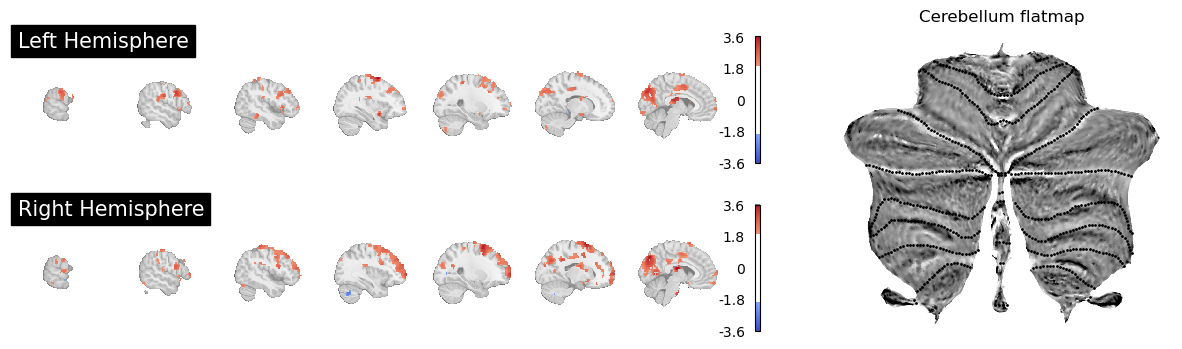

In [43]:
plot_stat_contours('zmap_ppi_region08_adoleVadult', mc='fdr', mc_alpha=0.05, thresh=2)

**Results:** No significant differences between adolescent and young adult connectivity between Crus I/II and the rest of the brain for all wins vs all losses. However, a liberal threshold shows stronger connectivity in the frontal pole and early visual cortex.

# Summary

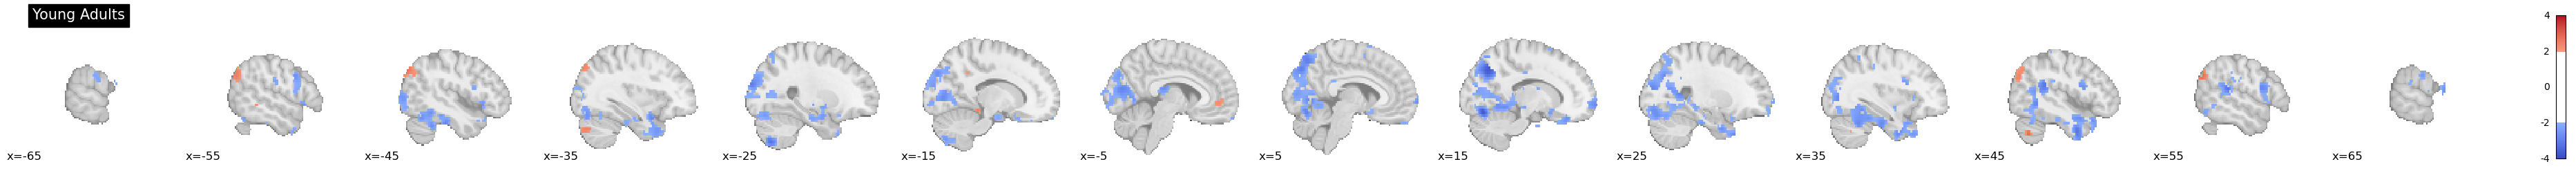

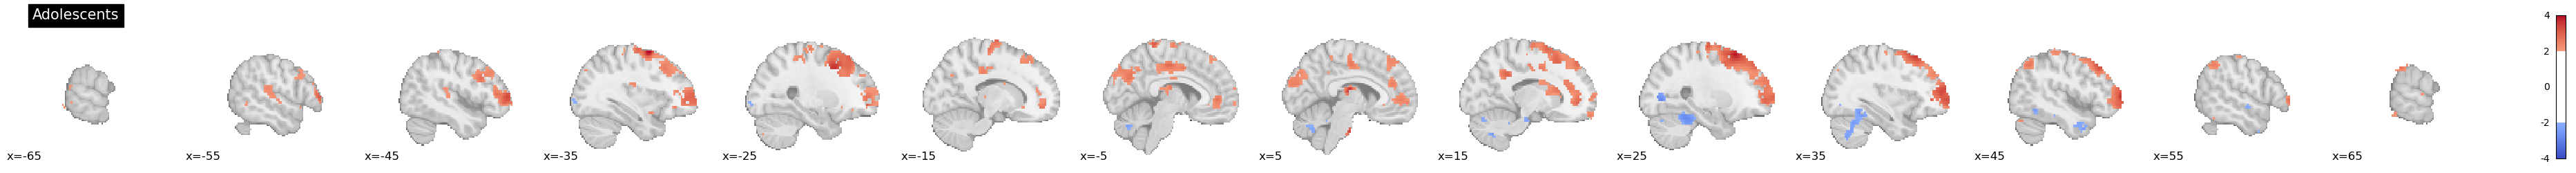

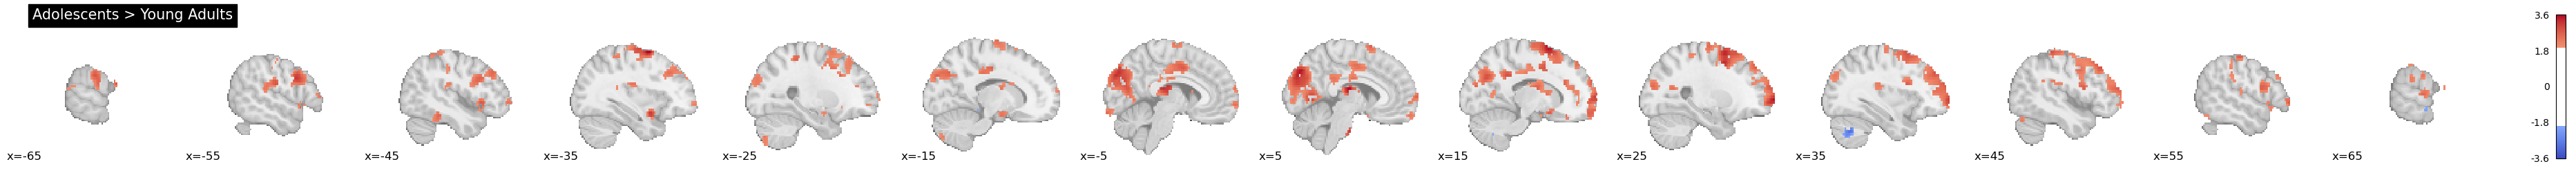

In [45]:
plot_stat_contours('zmap_ppi_region08_adult', mc='fdr', mc_alpha=0.05, thresh=2, view='straight', 
                   title='Young Adults')
plot_stat_contours('zmap_ppi_region08_adole', mc='fdr', mc_alpha=0.05, thresh=2, view='straight', 
                   title='Adolescents')
plot_stat_contours('zmap_ppi_region08_adoleVadult', mc='fdr', mc_alpha=0.05, thresh=2, view='straight', 
                   title='Adolescents > Young Adults')

Overall, there were no significant results after multiple comparisons correction (FDR < .05). However, some interesting trends hint at differences in Crus I/II connectivity with the cerebrum between adolescents and young adults for win trials over loss trials of the task. Connectivity between Crus I/II and the dlPFC, striatum, and early visual cortex is greater in adolescents than in young adults. This connectivity does not change significantly, when account for activity in either the reward or social networks.